In [12]:
from sklearn.datasets import fetch_openml
import numpy as np
from PIL import Image

# Load Data

In [2]:
x, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')

2


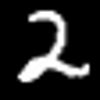

In [34]:
index = np.random.randint(0, len(x))

sample = x[index].reshape(28, 28)
print(y[index])

image = Image.fromarray(sample.astype(np.uint8))
image.resize((100, 100))

In [38]:
func = np.vectorize(lambda x: int(x))
y = func(y)

In [41]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958]))

# Train test split

In [42]:
from sklearn.model_selection import train_test_split

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, shuffle=True, random_state=42)

In [46]:
x_train.shape, x_test.shape

((42000, 784), (28000, 784))

# Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [70]:
model = LogisticRegression(max_iter=100, n_jobs=-1)

In [71]:
model.fit(x_train, y_train)

/home/denis/jupyter/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(n_jobs=-1)

In [72]:
accuracy_score(y_train, model.predict(x_train))

0.9383333333333334

In [73]:
accuracy_score(y_test, model.predict(x_test))

0.9173928571428571

# MLP

In [61]:
from sklearn.neural_network import MLPClassifier

In [66]:
model = MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=20)

In [67]:
model.fit(x_train, y_train)

/home/denis/jupyter/env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=20)

In [68]:
accuracy_score(y_train, model.predict(x_train))

0.9591428571428572

In [69]:
accuracy_score(y_test, model.predict(x_test))

0.9358214285714286

# Pytorch

In [84]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

## Create Dataset && Dataloader

In [183]:
class MnistDataset(Dataset):
    def __init__(self, x, y, device):
        self.x = torch.FloatTensor(x).to(device)
        self.y = torch.LongTensor(y).to(device)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i].reshape(1, 28, 28) / 255, self.y[i]

In [200]:
train_dataset = MnistDataset(x_train, y_train, 'cuda')
test_dataset = MnistDataset(x_test, y_test, 'cuda')

In [201]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [202]:
#(batch_size, in_channel, 28, 28)
#(batch_size, ....)

## CNN

In [203]:
#(batch_size, vector_size)

In [204]:
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            #(batch_size, 64, 42, 42)
            nn.AdaptiveMaxPool2d(output_size=1)
            # (batch_size, 64, 1)
        )
        
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(64, 10)
    
    def forward(self, x):
        return self.classifier(self.flatten(self.features(x)))

In [205]:
model = CnnModel().to('cuda')

## Fit

In [206]:
from tqdm import tqdm

def get_accuracy(model, loader):
    tp = n = 0
    for x_batch, y_batch in tqdm(loader):
        logits = model(x_batch)
        y_pred = logits.argmax(axis=1)
        
        n += y_batch.shape[0]
        tp += int((y_pred == y_batch).sum())
    return tp / n

In [210]:
def fit(model, train_loader, test_loader, num_epoch):
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    for epoch in range(num_epoch):
        model.train()
        for x_batch, y_batch in tqdm(train_loader):
            
            logits = model(x_batch)
            loss = loss_function(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        accuracy = get_accuracy(model, test_loader)
        
        print(f'Epoch {epoch + 1}, loss {loss:.3f}, accuracy: {accuracy:.3f}')

In [212]:
fit(model, train_loader, test_loader, num_epoch=5)

100%|████████████████████████████████████████| 875/875 [00:01<00:00, 696.89it/s]


Epoch 1, loss 0.021, accuracy: 0.981


100%|████████████████████████████████████████| 875/875 [00:01<00:00, 738.39it/s]


Epoch 2, loss 0.005, accuracy: 0.981


100%|████████████████████████████████████████| 875/875 [00:01<00:00, 684.31it/s]


Epoch 3, loss 0.050, accuracy: 0.981


100%|████████████████████████████████████████| 875/875 [00:01<00:00, 737.13it/s]


Epoch 4, loss 0.033, accuracy: 0.981


100%|████████████████████████████████████████| 875/875 [00:01<00:00, 681.80it/s]

Epoch 5, loss 0.001, accuracy: 0.981


# Analysis

In [225]:
index = np.random.randint(0, len(test_dataset))
sample, target = test_dataset[index]
sample = sample[None, ...]

softmax_function = nn.Softmax(dim=1)

logits = model(sample)
probs = softmax_function(logits)
probs = {index: float(probs[0][index]) for index in range(10)}

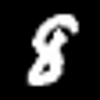

In [226]:
from torchvision.transforms.functional import to_pil_image

image = to_pil_image(sample[0, 0])
image.resize((100, 100))

In [227]:
print(f'true : {target}, predict: {int(logits.argmax(axis=1))}')

true : 8, predict: 8


In [228]:
probs

{0: 0.0002829681907314807,
 1: 2.549482014391202e-10,
 2: 0.0001806471700547263,
 3: 8.784749070400721e-07,
 4: 6.38801855856741e-09,
 5: 7.736236875643954e-05,
 6: 0.0014228221261873841,
 7: 6.120320916735977e-11,
 8: 0.9979777932167053,
 9: 5.7497680245433e-05}